In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import xlrd 
import json
import seaborn as sns
import statsmodels.api as sm
import ppscore as pps

# Import API key
from config import api_key, pwd
# Save config information.

In [3]:
#import excel file with obesity, unemployment, education
xls = pd.ExcelFile('Data/2016 County Health Rankings Data - v3.xls')
df = pd.read_excel(xls, 'Ranked Measure Data', skiprows=1)
df.head()

,FIPS,State,County,# Deaths,Years of Potential Life Lost Rate,95% CI - Low,95% CI - High,Quartile,% Fair/Poor,95% CI - Low.1,...,# Workers,% Drive Alone,95% CI - Low.20,95% CI - High.20,Quartile.33,# Workers who Drive Alone,% Long Commute - Drives Alone,95% CI - Low.21,95% CI - High.21,Quartile.34
0,1001.0,Alabama,Autauga,809.0,9215.1,8307.8,10122.3,2,19.4,18.8,...,24290.0,89.230136,87.152547,91.307725,4,21674.0,41.7,37.996787,45.403213,3
1,1003.0,Alabama,Baldwin,2506.0,7454.6,7001.9,7907.3,1,16.0,15.6,...,82134.0,84.071152,82.543906,85.598398,2,69051.0,36.8,34.609473,38.990527,3
2,1005.0,Alabama,Barbour,410.0,8499.9,7256.9,9742.8,1,25.7,25.0,...,9108.0,83.519982,81.092529,85.947436,2,7607.0,35.1,29.689536,40.510464,2
3,1007.0,Alabama,Bibb,414.0,11007.7,9346.3,12669.1,3,22.0,21.3,...,7773.0,84.034478,80.071760,87.997196,2,6532.0,45.7,38.399757,53.000243,4
4,1009.0,Alabama,Blount,876.0,8655.9,7799.8,9512.0,1,20.7,20.0,...,22168.0,85.073078,82.839898,87.306258,3,18859.0,59.0,54.229577,63.770423,4


In [4]:
df.rename(columns={ df.columns[108]: "Unemployment (%)" }, inplace = True)
df.rename(columns={ df.columns[31]: "Obesity (%)" }, inplace = True)
df.rename(columns={ df.columns[102]: "Some College (%)" }, inplace = True)
df.rename(columns={ df.columns[98]: "High School Grad (%)" }, inplace = True)

df['FIPS'] = df['FIPS'].astype(str).str.replace('.0', '', regex=False)

formatted_df = df.loc[:, ["FIPS", "State", "County", "Unemployment (%)", "Obesity (%)", "Some College (%)", "High School Grad (%)"]]
formatted_df.rename(columns={"FIPS": "CntyFips"}, inplace=True)

formatted_df.head()

,CntyFips,State,County,Unemployment (%),Obesity (%),Some College (%),High School Grad (%)
0,1001,Alabama,Autauga,5.883047,30.9,56.470750,83.000000
1,1003,Alabama,Baldwin,6.053720,26.7,62.335918,80.000000
2,1005,Alabama,Barbour,10.809275,40.8,43.358568,80.530303
3,1007,Alabama,Bibb,7.137850,40.1,48.927875,81.000000
4,1009,Alabama,Blount,6.146908,32.4,49.149934,84.975362


In [5]:
# Import data from url to get income per capita
url = "https://apps.bea.gov/api/data/?UserID=" + api_key + "&method=GetData&datasetname=Regional&TableName=CAINC1&LineCode=3&Year=2016&GeoFips=COUNTY&ResultFormat=json"

# Build partial query URL
query_url = f"{url}"

In [6]:
response = requests.get(query_url).json()
response

{'BEAAPI': {'Request': {'RequestParam': [{'ParameterName': 'GEOFIPS',
     'ParameterValue': 'COUNTY'},
    {'ParameterName': 'TABLENAME', 'ParameterValue': 'CAINC1'},
    {'ParameterName': 'RESULTFORMAT', 'ParameterValue': 'JSON'},
    {'ParameterName': 'LINECODE', 'ParameterValue': '3'},
    {'ParameterName': 'METHOD', 'ParameterValue': 'GETDATA'},
    {'ParameterName': 'DATASETNAME', 'ParameterValue': 'REGIONAL'},
    {'ParameterName': 'YEAR', 'ParameterValue': '2016'},
    {'ParameterName': 'USERID',
     'ParameterValue': '49AC8375-09BA-4F72-9621-7AA42E24BC81'}]},
  'Results': {'Statistic': 'Per capita personal income',
   'UnitOfMeasure': 'Dollars',
   'PublicTable': 'CAINC1 Per capita personal income (dollars)',
   'UTCProductionTime': '2020-05-10T23:41:58.270',
   'NoteRef': '2',
   'Dimensions': [{'Name': 'Code', 'DataType': 'string', 'IsValue': '0'},
    {'Name': 'GeoFips', 'DataType': 'string', 'IsValue': '0'},
    {'Name': 'GeoName', 'DataType': 'string', 'IsValue': '0'},
 

In [7]:
df_pci = pd.DataFrame(response['BEAAPI']['Results']['Data'])

df_pci.head()

,Code,GeoFips,GeoName,TimePeriod,CL_UNIT,UNIT_MULT,DataValue,NoteRef
0,CAINC1-3,01001,"Autauga, AL",2016,Dollars,0,"39,561",NaN
1,CAINC1-3,01003,"Baldwin, AL",2016,Dollars,0,"42,907",NaN
2,CAINC1-3,01005,"Barbour, AL",2016,Dollars,0,"31,595",NaN
3,CAINC1-3,01007,"Bibb, AL",2016,Dollars,0,"28,799",NaN
4,CAINC1-3,01009,"Blount, AL",2016,Dollars,0,"32,389",NaN


In [8]:
df_pci = df_pci.join(df_pci["GeoName"].str.split(", ", 1, expand=True).rename(columns={0:'County', 1:'State Abbr'}))
df_pci["County"] = df_pci["County"].str.replace("County", "")
df_pci["GeoFips"] = df_pci["GeoFips"].str.lstrip('0')

co_income = df_pci.loc[:, ["State Abbr", "County", "DataValue", "GeoFips"]]
co_income.rename(columns={"GeoFips": "CntyFips", "DataValue": "Income Per Capita ($)", "State Abbr": "State Abbr", "County": "County"}, inplace=True)
co_income = co_income[co_income["State Abbr"].astype(str) != "None"]
co_income['Income Per Capita ($)'] = co_income['Income Per Capita ($)'].astype(str).str.replace(',', '')
co_income.dropna(inplace=True)
co_income = co_income.loc[co_income['Income Per Capita ($)']!='(NA)']

county_cols = ["CntyFips", "State Abbr", "County", "Income Per Capita ($)"]
co_income = co_income[county_cols]

co_income.head()

,CntyFips,State Abbr,County,Income Per Capita ($)
0,1001,AL,Autauga,39561
1,1003,AL,Baldwin,42907
2,1005,AL,Barbour,31595
3,1007,AL,Bibb,28799
4,1009,AL,Blount,32389


In [9]:
#merging the health and income data into a new dataframe
merge_states_info = pd.merge(formatted_df, co_income, 
                             right_on=["CntyFips", "County"], left_on = ["CntyFips", "County"])
merge_states_info = merge_states_info.drop(['CntyFips'], axis=1)
merge_states_info.head()

,State,County,Unemployment (%),Obesity (%),Some College (%),High School Grad (%),State Abbr,Income Per Capita ($)
0,Alabama,Autauga,5.883047,30.9,56.470750,83.000000,AL,39561
1,Alabama,Baldwin,6.053720,26.7,62.335918,80.000000,AL,42907
2,Alabama,Barbour,10.809275,40.8,43.358568,80.530303,AL,31595
3,Alabama,Bibb,7.137850,40.1,48.927875,81.000000,AL,28799
4,Alabama,Blount,6.146908,32.4,49.149934,84.975362,AL,32389


In [10]:
SNAP_file = "Data/USCounty_Snap.csv"
SNAP_data = pd.read_csv(SNAP_file)
SNAP_data.head()

,Table with column headers in row 3,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,Table: County SNAP benefits recipients\nSourc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State FIPS code,County FIPS code,Name,July 2017,July 2016,July 2015,July 2014,July 2013,July 2012,July 2011,...,July 2003,July 2002,July 2001,July 2000,July 1999,July 1998,July 1997,July 1995,July 1993,July 1989
2,01,000,Alabama,"775,830","813,769","864,350","893,684","905,604","914,740","905,658",...,"491,910","463,998","435,235","405,325","396,931","409,160","434,632","510,271","561,128","435,296"
3,01,001,"Autauga County, AL","7,696","7,844","8,015","8,145","8,055","8,079","8,060",...,"3,594","3,352","3,035","2,814","2,700","2,589","2,771","3,611","4,608","3,739"
4,01,003,"Baldwin County, AL","20,241","21,406","22,920","24,563","24,402","23,169","22,184",...,"5,659","4,945","4,129","4,178","4,372","4,850","5,201","6,928","8,053","5,548"


In [11]:
new_header = SNAP_data.iloc[1] #grab the first row for the header
SNAP_data.columns = new_header
SNAP_data.head()

1,State FIPS code,County FIPS code,Name,July 2017,July 2016,July 2015,July 2014,July 2013,July 2012,July 2011,...,July 2003,July 2002,July 2001,July 2000,July 1999,July 1998,July 1997,July 1995,July 1993,July 1989
0,Table: County SNAP benefits recipients\nSourc...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State FIPS code,County FIPS code,Name,July 2017,July 2016,July 2015,July 2014,July 2013,July 2012,July 2011,...,July 2003,July 2002,July 2001,July 2000,July 1999,July 1998,July 1997,July 1995,July 1993,July 1989
2,01,000,Alabama,"775,830","813,769","864,350","893,684","905,604","914,740","905,658",...,"491,910","463,998","435,235","405,325","396,931","409,160","434,632","510,271","561,128","435,296"
3,01,001,"Autauga County, AL","7,696","7,844","8,015","8,145","8,055","8,079","8,060",...,"3,594","3,352","3,035","2,814","2,700","2,589","2,771","3,611","4,608","3,739"
4,01,003,"Baldwin County, AL","20,241","21,406","22,920","24,563","24,402","23,169","22,184",...,"5,659","4,945","4,129","4,178","4,372","4,850","5,201","6,928","8,053","5,548"


In [12]:
SNAP_data_df = SNAP_data[2:]
SNAP_data_df = SNAP_data_df.join(SNAP_data_df["Name"].str.split(",", 1, expand=True).rename(columns={0:'County', 1:'State Abbr'}))
SNAP_data_df["County"] = SNAP_data_df["County"].str.replace("County", "")

#referencing data needed for 2016 analysis and creating new dataframe
reduced_SNAP_df = SNAP_data_df.loc[:, ["State Abbr", "County", "July 2017"]]
reduced_SNAP_df.rename(columns={"July 2017": "SNAP Recipients"}, inplace=True)
reduced_SNAP_df = reduced_SNAP_df[reduced_SNAP_df["State Abbr"].astype(str) != "None"]
reduced_SNAP_df['SNAP Recipients'] = reduced_SNAP_df['SNAP Recipients'].str.replace(',', '')

reduced_SNAP_df.head()

,State Abbr,County,SNAP Recipients
3,AL,Autauga,7696
4,AL,Baldwin,20241
5,AL,Barbour,6124
6,AL,Bibb,3504
7,AL,Blount,6402


In [13]:
#removing space after data to so it can be merged into new dataframe
reduced_SNAP_df['State Abbr'] = reduced_SNAP_df['State Abbr'].str.strip()
reduced_SNAP_df['County'] = reduced_SNAP_df['County'].str.strip()
merge_states_info['State Abbr'] = merge_states_info['State Abbr'].str.strip()
merge_states_info['County'] = merge_states_info['County'].str.strip()

#Merging data
all_merged_df = pd.merge(merge_states_info, reduced_SNAP_df, 
                         right_on = ["State Abbr","County"], left_on = ["State Abbr","County"])
all_merged_df.head()

,State,County,Unemployment (%),Obesity (%),Some College (%),High School Grad (%),State Abbr,Income Per Capita ($),SNAP Recipients
0,Alabama,Autauga,5.883047,30.9,56.470750,83.000000,AL,39561,7696
1,Alabama,Baldwin,6.053720,26.7,62.335918,80.000000,AL,42907,20241
2,Alabama,Barbour,10.809275,40.8,43.358568,80.530303,AL,31595,6124
3,Alabama,Bibb,7.137850,40.1,48.927875,81.000000,AL,28799,3504
4,Alabama,Blount,6.146908,32.4,49.149934,84.975362,AL,32389,6402


In [14]:
Pop_file = "Data/co-est2019-alldata.csv"
Pop_data = pd.read_csv(Pop_file,encoding='latin-1')
Pop_data.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [15]:
Pop_data_df = Pop_data
Pop_data_df["CTYNAME"] = Pop_data_df["CTYNAME"].str.replace("County", "")
Pop_data_df.rename(columns={"CTYNAME": "County"}, inplace=True)

reduced_Pop_df = Pop_data_df.loc[:, ["SUMLEV", "STNAME", "County", "POPESTIMATE2016"]]
reduced_Pop_df.rename(columns={"POPESTIMATE2016": "Population", "STNAME": "State"}, inplace=True)
reduced_Pop_df = reduced_Pop_df[reduced_Pop_df["SUMLEV"].astype(str) != "40"]

reduced_Pop2_df = reduced_Pop_df.drop(['SUMLEV'], axis=1)

reduced_Pop2_df.head()

,State,County,Population
1,Alabama,Autauga,55243
2,Alabama,Baldwin,207601
3,Alabama,Barbour,25806
4,Alabama,Bibb,22586
5,Alabama,Blount,57494


In [16]:
reduced_Pop2_df['County'] = reduced_Pop2_df['County'].str.strip()
#Merge County Population data and SNAP data
merge_population_info = pd.merge(reduced_Pop2_df, all_merged_df, 
                             right_on=["State", "County"], left_on = ["State", "County"])

#Calculate SNAP percentage by county (SNAP recipients divided by County Population)

merge_population_info["SNAP Recipients"] = merge_population_info["SNAP Recipients"].astype(int)
merge_population_info["Population"] = merge_population_info["Population"].astype(int)

SNAP_Percent = merge_population_info["SNAP Recipients"]/merge_population_info["Population"]*100

merge_population_info['SNAP Recipients (%)'] = SNAP_Percent

merge_population_info.head()

,State,County,Population,Unemployment (%),Obesity (%),Some College (%),High School Grad (%),State Abbr,Income Per Capita ($),SNAP Recipients,SNAP Recipients (%)
0,Alabama,Autauga,55243,5.883047,30.9,56.470750,83.000000,AL,39561,7696,13.931177
1,Alabama,Baldwin,207601,6.053720,26.7,62.335918,80.000000,AL,42907,20241,9.749953
2,Alabama,Barbour,25806,10.809275,40.8,43.358568,80.530303,AL,31595,6124,23.730915
3,Alabama,Bibb,22586,7.137850,40.1,48.927875,81.000000,AL,28799,3504,15.514035
4,Alabama,Blount,57494,6.146908,32.4,49.149934,84.975362,AL,32389,6402,11.135075


In [32]:
#final data merge to include all sources

merge_population_info["Income Per Capita ($)"] = merge_population_info["Income Per Capita ($)"].astype(int)
final_data=merge_population_info.loc[:, ["State", "State Abbr", "County", "Obesity (%)", "Unemployment (%)", "SNAP Recipients (%)", 
                                  "Some College (%)", "High School Grad (%)", "Income Per Capita ($)"]]

final_data.head()

,State,State Abbr,County,Obesity (%),Unemployment (%),SNAP Recipients (%),Some College (%),High School Grad (%),Income Per Capita ($)
0,Alabama,AL,Autauga,30.9,5.883047,13.931177,56.470750,83.000000,39561
1,Alabama,AL,Baldwin,26.7,6.053720,9.749953,62.335918,80.000000,42907
2,Alabama,AL,Barbour,40.8,10.809275,23.730915,43.358568,80.530303,31595
3,Alabama,AL,Bibb,40.1,7.137850,15.514035,48.927875,81.000000,28799
4,Alabama,AL,Blount,32.4,6.146908,11.135075,49.149934,84.975362,32389


In [33]:
final_data.dropna(inplace=True)
final_data.count()

State                    2483
State Abbr               2483
County                   2483
Obesity (%)              2483
Unemployment (%)         2483
SNAP Recipients (%)      2483
Some College (%)         2483
High School Grad (%)     2483
Income Per Capita ($)    2483
dtype: int64

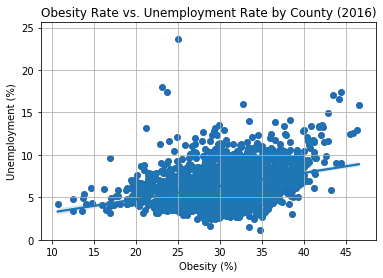

In [21]:
#Obesity vs Unemployment
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs Unemployment
#max unemployment limits
unemp_limit_min = final_data["Unemployment (%)"].min()
# unemp_limit_min
unemp_limit_max = final_data["Unemployment (%)"].max()
# unemp_limit_max

#Obesity vs Unemployment
obesity_vs_unemp = plt.scatter(final_data["Obesity (%)"], final_data["Unemployment (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(0, unemp_limit_max+2)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("Unemployment (%)")

#add header
plt.title(f"Obesity Rate vs. Unemployment Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["Unemployment (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_Unemployment.png")

# Show plot
plt.show()


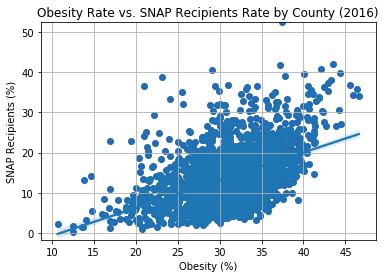

In [22]:
#Obesity vs SNAP Recipients
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs SNAP Recipients
#max SNAP Recipients limits
snap_limit_min = final_data["SNAP Recipients (%)"].min()
# unemp_limit_min
snap_limit_max = final_data["SNAP Recipients (%)"].max()
# unemp_limit_max

#Obesity vs SNAP Recipients
obesity_vs_snap = plt.scatter(final_data["Obesity (%)"], final_data["SNAP Recipients (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(snap_limit_min-2, snap_limit_max)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("SNAP Recipients (%)")

#add header
plt.title(f"Obesity Rate vs. SNAP Recipients Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["SNAP Recipients (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_SNAP_Recipients.png")

# Show plot
plt.show()

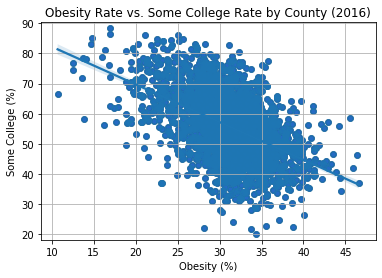

In [23]:
#Obesity vs Some College
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs Some College
#max Some College limits
college_limit_min = final_data["Some College (%)"].min()
# college_limit_min
college_limit_max = final_data["Some College (%)"].max()
# college_limit_max

#Obesity vs Some College
obesity_vs_college = plt.scatter(final_data["Obesity (%)"], final_data["Some College (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(college_limit_min-2, college_limit_max+2)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("Some College (%)")

#add header
plt.title(f"Obesity Rate vs. Some College Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["Some College (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_Some_College.png")

# Show plot
plt.show()

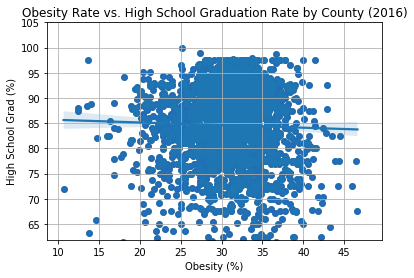

In [24]:
#Obesity vs High School Graduate
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs High School Graduate
#max High School Graduate limits
hs_limit_min = final_data["High School Grad (%)"].min()
# highschool_limit_min
hs_limit_max = final_data["High School Grad (%)"].max()
# highschool_limit_max

#Obesity vs High School Graduate
obesity_vs_hs = plt.scatter(final_data["Obesity (%)"], final_data["High School Grad (%)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+3)
plt.ylim(hs_limit_min+40, hs_limit_max+5)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("High School Grad (%)")

#add header
plt.title(f"Obesity Rate vs. High School Graduation Rate by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["High School Grad (%)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_hs_grad.png")

# Show plot
plt.show()

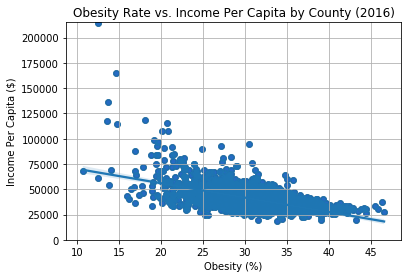

In [25]:
#Obesity vs Income Per Capita
#obtain the x and y coordinates for x and y coordinates

#get limits for x axis
x_limit_min = final_data["Obesity (%)"].min()
# x_limit_min
x_limit_max = final_data["Obesity (%)"].max()
# x_limit_max


#graphing for Obesity vs Income Per Capita
#max income limits
income_limit_min = final_data["Income Per Capita ($)"].min()
# income_limit_min
income_limit_max = final_data["Income Per Capita ($)"].max()
# income_limit_max

#Obesity vs Income Per Capita
obesity_vs_income = plt.scatter(final_data["Obesity (%)"], final_data["Income Per Capita ($)"], marker="o", 
                               facecolors="blue", edgecolors="black", s=30, alpha=0.75)
plt.scatter

# Incorporate the other graph properties

# Set your x and y limits
plt.xlim(x_limit_min-2, x_limit_max+2)
plt.ylim(0, income_limit_max+1000)

#label x and y axis

plt.xlabel("Obesity (%)")
plt.ylabel("Income Per Capita ($)")

#add header
plt.title(f"Obesity Rate vs. Income Per Capita by County (2016)")

#add trendline
sns.regplot(final_data["Obesity (%)"],final_data["Income Per Capita ($)"])


# Set a grid on the plot
plt.grid()

# Save Figure
plt.savefig("Obesity_vs_Income_Per_Capita.png")

# Show plot
plt.show()

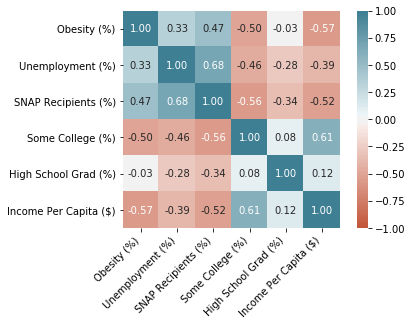

In [44]:
#Correlation Matrix plots
corr = final_data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, 
    fmt=".2f"
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right',    
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig("Obesity_Correlation_Matrix.png", figsize=(16,12))

# Show plot
plt.show()

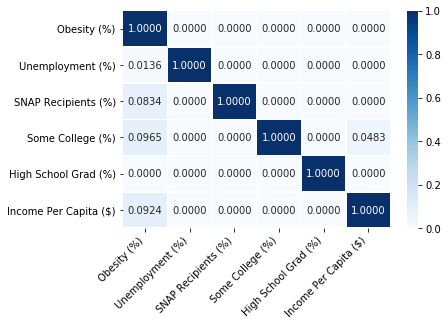

In [45]:
#pps matrix plot
pps_data=final_data.loc[:, ["Obesity (%)", "Unemployment (%)", "SNAP Recipients (%)", 
                                  "Some College (%)", "High School Grad (%)", "Income Per Capita ($)"]]
ax = sns.heatmap(pps.matrix(pps_data), vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True, fmt=".4f")
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
;

# Save Figure
plt.savefig("Obesity_PPS_Matrix.png", figsize=(20,24))

# Show plot
plt.show()